In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import DecisionBoundaryDisplay

In [2]:
df = pd.read_csv('data/speed-dating-preprocessed.csv')
df.head()

,id,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,...,d_yoga,interests_correlate,d_interests_correlate,like,d_like,met,decision,decision_o,match,field_encoded
0,1,0,1,female,21,27,6,medium age difference,Asian/Pacific Islander/Asian-American,European/Caucasian-American,...,low,0,[0-0.33],7,average,0,1,0,0,48
1,2,0,1,female,21,22,1,no age difference,Asian/Pacific Islander/Asian-American,European/Caucasian-American,...,low,1,[0.33-1],7,average,1,1,0,0,48
2,3,1,1,female,21,22,1,no age difference,Asian/Pacific Islander/Asian-American,Asian/Pacific Islander/Asian-American,...,low,0,[0-0.33],7,average,1,1,1,1,48
3,4,0,1,female,21,23,2,small age difference,Asian/Pacific Islander/Asian-American,European/Caucasian-American,...,low,1,[0.33-1],7,average,0,1,1,1,48
4,5,0,1,female,21,24,3,small age difference,Asian/Pacific Islander/Asian-American,Latino/Hispanic American,...,low,0,[0-0.33],6,average,0,1,1,1,48


## Encoding
Since classifier work with distance measurements we need to encode the categorical values.
I compare One Hot Encoding with Label Encoding


In [3]:
# drop d_interests_correlate column and field_encoded
df = df.drop(columns=['d_interests_correlate', 'field_encoded'])


# encode all categorical values with LabelEncoder
df_LE = df.apply(LabelEncoder().fit_transform)
# build smaller df without unnecessary categorical values - > One Hot encoded
df_OC = df
for column in df_OC:
    if 'd_' in column and column != 'd_age':
        df_OC = df_OC.drop(columns=[column])

final_df = df
n_columns = []
race_o = ['o_Asian/Pacific Islander/Asian-American','o_Black/African American','o_European/Caucasian-American','o_Latino/Hispanic American','o_Other']
for column in df_OC:
    if column in ['gender','race', 'race_o', 'field']:
        n_columns.append(pd.get_dummies(df_OC[column], prefix=column))
        df_OC = df_OC.drop(column,axis = 1)
        
        
df_OC = df_OC.join(n_columns)

    
# set labelEncoded frame as default
df = df_LE







In [4]:
# splitting the data 70/30 and scale X vector


data = df.loc[:, df.columns != 'match']
data = pd.DataFrame(StandardScaler().fit_transform(data),columns = data.columns)
test = df['match']
X_train, X_test, y_train, y_test = train_test_split(data, test, test_size=0.3, random_state=42)

# One Hot Encoded Frame
data_oc = df_OC.loc[:, df_OC.columns != 'match']
data_oc = pd.DataFrame(StandardScaler().fit_transform(data_oc),columns = data_oc.columns)
target_oc = df_OC['match']
X_train_oc, X_test_oc, y_train_oc, y_test_oc = train_test_split(data_oc, target_oc, test_size=0.3, random_state=42)


Accuracy: 0.8443008225616921
Accuracy in CV: 0.8129801334793992


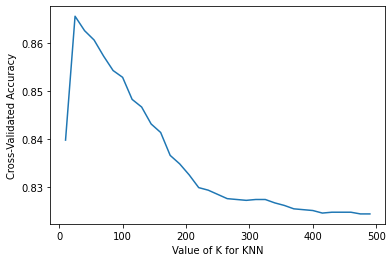

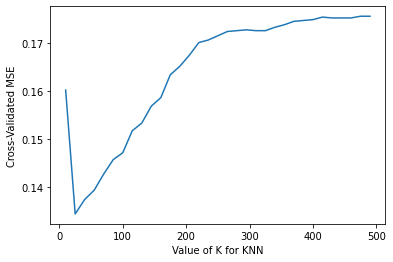

max Accuracy: 0.8655018685562004
min MSE: 0.13449813144379957


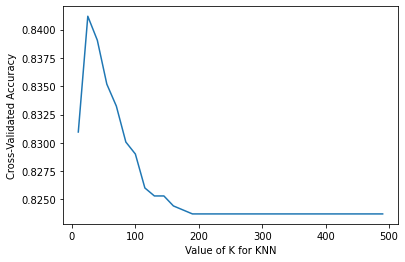

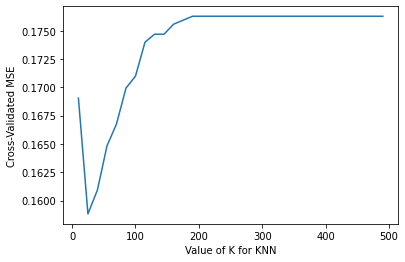

max Accuracy: 0.8411790939250559
min MSE: 0.15882090607494423


In [5]:
# LANGE WARTEZEIT 

K = 5
weights = "distance"
# ColorMap
cmap_light = ListedColormap(["orange", "cyan"])
cmap_bold = ["darkorange", "c"]

#KNN Model
knn = KNeighborsClassifier(K,weights=weights)
knn.fit(X_train,y_train)
#Predict the response for test dataset
y_pred = knn.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# CROSS VALIDATION 
scores = cross_val_score(knn, data, test, cv=5, scoring='accuracy')
print("Accuracy in CV:",scores.mean())
# choose k between 10 to 500
k_range = range(10,500,15)
k_scores = []
k_loss_scores = []
# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, weights=weights)
    scores = cross_val_score(knn, data, test, cv=5, scoring='accuracy')
    loss = abs(cross_val_score(knn, data, test, cv=5, scoring='neg_mean_squared_error'))
    k_scores.append(scores.mean())
    k_loss_scores.append(loss.mean())
# plot to see clearly
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()
plt.plot(k_range, k_loss_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated MSE')
plt.show()

print("max Accuracy:",max(k_scores))
print("min MSE:",min(k_loss_scores))

# CV onthe one hot encoded dataframe
# choose k between 10 to 500
k_range = range(10,500,15)
k_scores = []
k_loss_scores = []
# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, weights=weights)
    scores = cross_val_score(knn, data_oc, target_oc, cv=5, scoring='accuracy')
    loss = abs(cross_val_score(knn, data_oc, target_oc, cv=5, scoring='neg_mean_squared_error'))
    k_scores.append(scores.mean())
    k_loss_scores.append(loss.mean())
# plot to see clearly
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()
plt.plot(k_range, k_loss_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated MSE')
plt.show()

print("max Accuracy:",max(k_scores))
print("min MSE:",min(k_loss_scores))



In [6]:
# Logic Regression

# labelencoded frame
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 Score:",metrics.f1_score(y_test, y_pred))
print("ROC AUC Score:",metrics.roc_auc_score(y_test, y_pred))

# CV
scores = cross_val_score(clf, data, test, cv=5, scoring='accuracy')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

# one hot encoded frame
clf.fit(X_train_oc, y_train_oc)
y_pred_oc = clf.predict(X_test_oc)
print("Accuracy:",metrics.accuracy_score(y_test_oc, y_pred_oc))
print("F1 Score:",metrics.f1_score(y_test_oc, y_pred_oc))
print("ROC AUC Score:",metrics.roc_auc_score(y_test_oc, y_pred_oc))

# CV
scores = cross_val_score(clf, data_oc, target_oc, cv=5, scoring='accuracy')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


Accuracy: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0
1.00 accuracy with a standard deviation of 0.00
Accuracy: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0
1.00 accuracy with a standard deviation of 0.00


In [7]:
# DECISION TREE

# Labelencoded Frame
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 Score:",metrics.f1_score(y_test, y_pred))
print("ROC AUC Score:",metrics.roc_auc_score(y_test, y_pred))

# ONE HOT ENCODED Frame
clf.fit(X_train_oc, y_train_oc)
y_pred_oc = clf.predict(X_test_oc)
print("Accuracy:",metrics.accuracy_score(y_test_oc, y_pred_oc))
print("F1 Score:",metrics.f1_score(y_test_oc, y_pred_oc))
print("ROC AUC Score:",metrics.roc_auc_score(y_test_oc, y_pred_oc))

# CV
scores = cross_val_score(clf, data_oc, target_oc, cv=5, scoring='accuracy')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))



Accuracy: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0
Accuracy: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0
1.00 accuracy with a standard deviation of 0.00
